# Clustering Client

In [ ]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:50179")
client

In [1]:
import dask.array as da
import dask.dataframe as dd
import pandas as pd
import numpy as np
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn import decomposition
from sklearn import manifold
from sklearn import metrics
from dask_ml import preprocessing


sns.set_style("whitegrid")
%matplotlib inline
warnings.filterwarnings('ignore')

## 1 - Import des jeux de données

In [ ]:
data_3_months = dd.read_csv(
    "data/clean/data_3_months.csv", parse_dates=["order_purchase_timestamp"])
data_6_months = dd.read_csv(
    "data/clean/data_6_months.csv", parse_dates=["order_purchase_timestamp"])
data_9_months = dd.read_csv(
    "data/clean/data_9_months.csv", parse_dates=["order_purchase_timestamp"])
data_12_months = dd.read_csv(
    "data/clean/data_12_months.csv", parse_dates=["order_purchase_timestamp"])
data_15_months = dd.read_csv(
    "data/clean/data_15_months.csv", parse_dates=["order_purchase_timestamp"])
data_18_months = dd.read_csv(
    "data/clean/data_18_months.csv", parse_dates=["order_purchase_timestamp"])
data_all = dd.read_csv("data/clean/data_all.csv",
                       parse_dates=["order_purchase_timestamp"])

## 2 - Features engineering

In [ ]:
def review(df):
    grouped = df.groupby("customer_unique_id").agg(
        {"review_score": ["count", "min", "max", "mean"]})
    grouped.columns = ["_".join(x) for x in grouped.columns.ravel()]
    return grouped


def value(df):
    grouped = df.groupby("customer_unique_id").agg({
        "payment_value": ["mean", "min", "max"]})
    grouped.columns = ["_".join(x) for x in grouped.columns.ravel()]
    return grouped


def payment_facility(df):
    df_pf = df.groupby("customer_unique_id").agg({
        "payment_installments": "sum"
    })
    cond_mask = (df_pf["payment_installments"] > 1)

    df_pf["payment_installments"] = df_pf["payment_installments"].mask(
        cond=cond_mask, other=0)
    df_pf = df_pf.rename(columns={"payment_installments": "payment_facility"})
    return df_pf


def category_transf(df):
    df_ct = dd.get_dummies(df[["product_category_name", "customer_unique_id"]].categorize(
    ), columns=['product_category_name'], prefix="PCat").groupby(['customer_unique_id']).sum()
    return df_ct


def state(df):
    df_state = dd.get_dummies(df[["customer_state", "customer_unique_id"]].categorize(
    ), columns=["customer_state"], prefix="CState").groupby(["customer_unique_id"]).sum()
    return df_state


def payment(df):
    df_p = dd.get_dummies(df[["payment_type", "customer_unique_id"]].categorize(
    ), columns=['payment_type'], prefix="PType").groupby(['customer_unique_id']).sum()
    return df_p


def rfm(df):
    df = df.compute()
    return df.groupby("customer_unique_id").agg(
        recency=("order_purchase_timestamp", lambda date: (
            df["order_purchase_timestamp"].max() - date.max()).days),
        frequency=("order_id", "count"),
        monetary=("payment_value", sum))


def features_engineering(df):
    df_fe = dd.merge(rfm(df), value(df))
    df_fe = dd.merge(df_fe, review(df))
    df_fe = dd.merge(df_fe, payment(df))
    df_fe = dd.merge(df_fe, state(df))
    df_fe = dd.merge(df_fe, category_transf(df))
    df_fe = dd.merge(df_fe, payment_facility(df))
    return df_fe

In [ ]:
data_3_months_fe = features_engineering(data_3_months).compute()
data_3_months_fe.head()

In [ ]:
data_6_months_fe = features_engineering(data_6_months).compute()
data_6_months_fe.head()

In [ ]:
data_9_months_fe = features_engineering(data_9_months).compute()
data_9_months_fe.head()

In [ ]:
data_12_months_fe = features_engineering(data_12_months).compute()
data_12_months_fe.head()

In [ ]:
data_15_months_fe = features_engineering(data_15_months).compute()
data_15_months_fe.head()

In [ ]:
data_18_months_fe = features_engineering(data_18_months).compute()
data_18_months_fe.head()

In [ ]:
data_all_fe = features_engineering(data_all).compute()
data_all_fe.head()

On enregistre les jeux de données pour revenir dessus plus tard

In [ ]:
data_3_months_fe.to_csv("data/fe/data_3_months.csv")
data_6_months_fe.to_csv("data/fe/data_6_months.csv")
data_9_months_fe.to_csv("data/fe/data_9_months.csv")
data_12_months_fe.to_csv("data/fe/data_12_months.csv")
data_15_months_fe.to_csv("data/fe/data_15_months.csv")
data_18_months_fe.to_csv("data/fe/data_18_months.csv")
data_all_fe.to_csv("data/fe/data_all.csv")

## 3 - Préparation

### 3.1 - Suppression des variables inutiles

In [ ]:
del data_3_months_fe
del data_6_months_fe
del data_9_months_fe
del data_12_months_fe
del data_15_months_fe
del data_18_months_fe
del data_all_fe

### 3.2 - Import des jeux de donnée après features engineering

In [3]:
data_3_months = pd.read_csv(
    "data/fe/data_3_months.csv", index_col="customer_unique_id")
data_6_months = pd.read_csv(
    "data/fe/data_6_months.csv", index_col="customer_unique_id")
data_9_months = pd.read_csv(
    "data/fe/data_9_months.csv", index_col="customer_unique_id")
data_12_months = pd.read_csv(
    "data/fe/data_12_months.csv", index_col="customer_unique_id")
data_15_months = pd.read_csv(
    "data/fe/data_15_months.csv", index_col="customer_unique_id")
data_18_months = pd.read_csv(
    "data/fe/data_18_months.csv", index_col="customer_unique_id")
data_all = pd.read_csv("data/fe/data_all.csv", index_col="customer_unique_id")

### 3.3 - Normalisation

In [4]:
standardize = preprocessing.StandardScaler()
standardize.fit(data_3_months.iloc[:])
data_3_months = standardize.transform(data_3_months.iloc[:])

### 3.4 - Déclaration des fonctions

In [5]:
def best_cluster_kmean(data, title):
    """Test the best number of cluster based on
        silhouette score from 2 to 25 with KMean algorithm.

        This function display a plot with silhouette score / # of cluster
    """
    km_cluster_number = []
    km_score = []
    for n in range(2, 25):
        kmean = KMeans(n_clusters=n, n_init=100, max_iter=3000, random_state=0)
        kmean.fit(data)
        km_cluster_number.append(n)
        km_score.append(silhouette_score(
            data, kmean.labels_, metric='euclidean'))
    plt.figure(figsize=(10, 5))
    plt.plot(km_cluster_number, km_score, color="skyblue", lw=2)
    plt.xlabel("Nombre de cluster")
    plt.ylabel("Score de silhouette")
    plt.title("{} Kmean".format(title))
    plt.tight_layout()
    plt.show()


def best_cluster_hier(data, title):
    """Test the best number of cluster based on
        silhouette score from 2 to 25 with Hierarchic Clustering algorithm.

        This function display a plot with silhouette score / # of cluster
    """
    hier_cluster_number = []
    hier_score = []
    for n in range(2, 25):
        clust_hier = AgglomerativeClustering(n_clusters=n)
        clust_hier.fit(data)
        hier_cluster_number.append(n)
        hier_score.append(silhouette_score(
            data, clust_hier.labels_, metric="euclidean"))
    plt.figure(figsize=(10, 5))
    plt.plot(hier_cluster_number, hier_score, color="skyblue", lw=2)
    plt.xlabel("Nombre de cluster")
    plt.ylabel("Score de silhouette")
    plt.title("{} Clustering Hierarchique".format(title))
    plt.tight_layout()
    plt.show()


def kmean_labels(n_clusters, fit_var):
    """This function return the predicted labels for 
        a number of cluster
    """
    kmean = KMeans(n_clusters=n_clusters, n_init=100,
                   max_iter=3000, random_state=0)
    kmean.fit(fit_var)
    return kmean.labels_


def kpca_projected(n_components, fit_var):
    """This function return the projected value after a KernelPCA decomposition"""
    kpca = decomposition.KernelPCA(
        n_components=n_components, kernel="cosine", random_state=0)
    return kpca.fit_transform(fit_var)


def isomap_projected(fit_var):
    """This function return the projected value after a ISOMap manifold"""
    isomap = manifold.Isomap(n_components=2, n_jobs=-1)
    return isomap.fit_transform(fit_var)


def tsne_projected(fit_var):
    """This function return the projected value after a TSNE manifold"""
    tsne = manifold.TSNE(n_components=2, perplexity=70, random_state=0)
    return tsne.fit_transform(fit_var)


def pca_projected(n_components, fit_var):
    """This function return the projected value after a PCA decomposition"""
    pca = decomposition.PCA(n_components=n_components, random_state=0)
    return pca.fit_transform(fit_var)


def mds_projected(fit_var):
    """This function return the projected value after a MDS manifold"""
    mds = manifold.MDS(n_components=2, random_state=0)
    return mds.fit_transform(fit_var)


def plot_with_tsne(fit_var, labels):
    """This function display a TSNE visualisation"""
    tsne = manifold.TSNE(n_components=2, perplexity=70, random_state=0)
    X_tsne = tsne.fit_transform(fit_var)
    plt.figure(figsize=(10, 5))
    plt.scatter(X_tsne[:, 0], X_tsne[:, 1], marker='.',
                c=labels, cmap=plt.get_cmap("tab20"))
    plt.tight_layout()
    plt.show()

## 4 - Clustering

### 4.1 - K-means (Baseline)

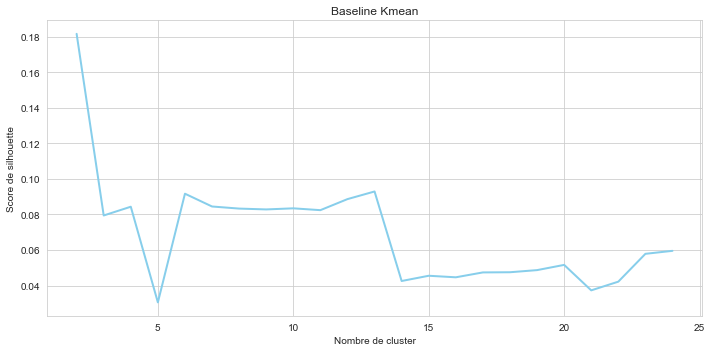

In [6]:
best_cluster_kmean(data_3_months, "Baseline")

### 4.2 - DBSCAN (Baseline)

In [7]:
dbscan_clust = DBSCAN(eps=0.8, min_samples=10)
dbscan_clust.fit(data_3_months)

DBSCAN(algorithm='auto', eps=0.8, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=10, n_jobs=None, p=None)

In [8]:
dbscan_labels = dbscan_clust.labels_

In [9]:
n_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
n_clusters

19

In [10]:
silhouette_score(data_3_months, dbscan_labels)

-0.35095667658863056

In [11]:
list(dbscan_labels).count(-1)

4506

### 4.3 - Clustering Hierarchique (Baseline)

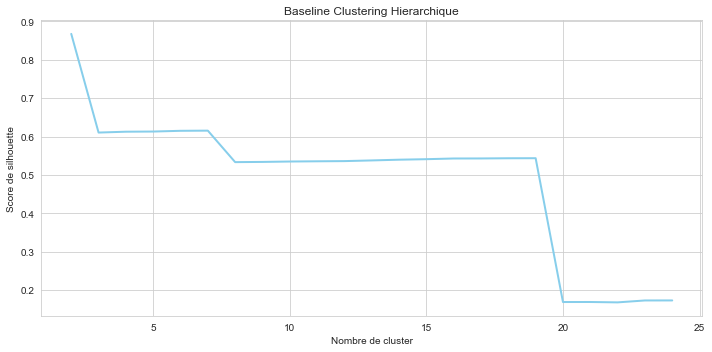

In [12]:
best_cluster_hier(data_3_months, "Baseline")

## 5- Réduction de dimension

In [6]:
X = data_3_months.values

### 5.1 - Linear PCA
#### 5.1.1 - Decomposition et projection

In [14]:
pca = decomposition.PCA(n_components=94)
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=94, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

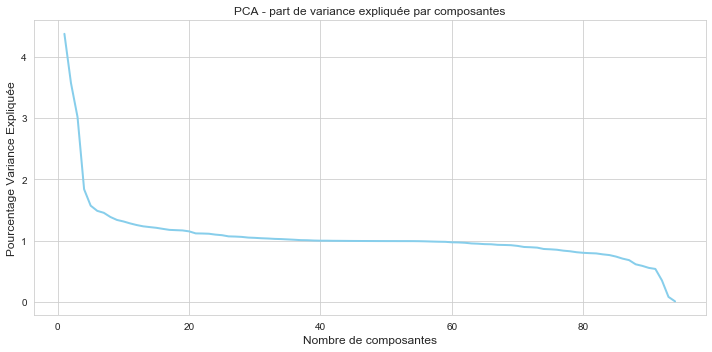

In [15]:
components = range(1, len(pca.explained_variance_ratio_) + 1)
plt.figure(figsize=(10, 5))
plt.plot(components, pca.explained_variance_ratio_*100, color='skyblue', lw=2)
plt.xlabel('Nombre de composantes', fontsize=12)
plt.ylabel('Pourcentage Variance Expliquée', fontsize=12)
plt.title('PCA - part de variance expliquée par composantes')
plt.tight_layout()
plt.show()

In [16]:
X_pca_projected = pca_projected(10, X)

#### 5.1.2 - Clustering
##### 5.1.2.1 - K-means

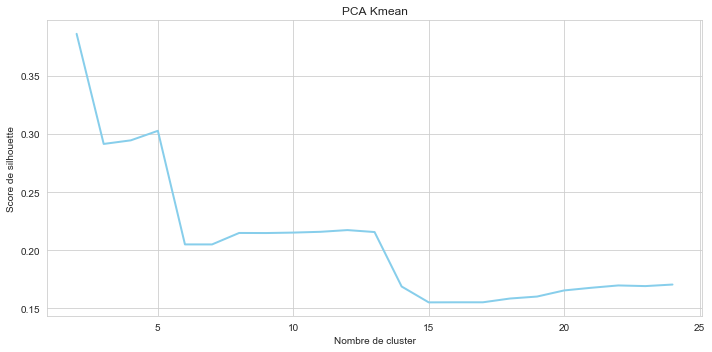

In [17]:
best_cluster_kmean(X_pca_projected, "PCA")

##### 5.1.2.2 - Clustering Hierarchique

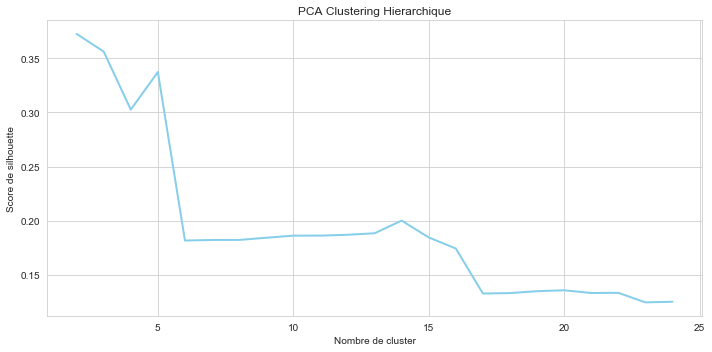

In [18]:
best_cluster_hier(X_pca_projected, "PCA")

### 5.2 -  Kernel PCA
#### 5.2.1 - Decomposition et projection

In [19]:
kpca = decomposition.KernelPCA(n_components=X.shape[1], kernel="cosine")
kpca.fit(X)

KernelPCA(alpha=1.0, coef0=1, copy_X=True, degree=3, eigen_solver='auto',
          fit_inverse_transform=False, gamma=None, kernel='cosine',
          kernel_params=None, max_iter=None, n_components=101, n_jobs=None,
          random_state=None, remove_zero_eig=False, tol=0)

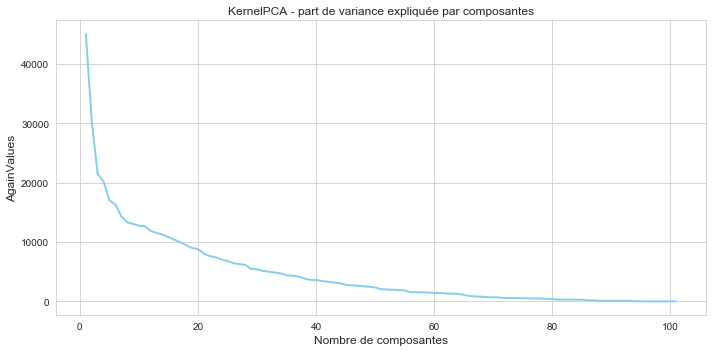

In [20]:
components = range(1, len(kpca.lambdas_)+1)
plt.figure(figsize=(10, 5))
plt.plot(components, kpca.lambdas_*100, color='skyblue', lw=2)
plt.xlabel('Nombre de composantes', fontsize=12)
plt.ylabel('AgainValues', fontsize=12)
plt.title('KernelPCA - part de variance expliquée par composantes')
plt.tight_layout()
plt.show()

In [21]:
X_kpca_projected = kpca_projected(10, X)

#### 5.2.2 - Clustering
##### 5.2.2.1 - K-means

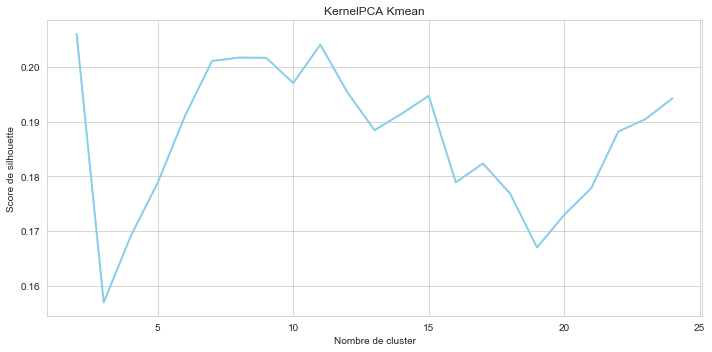

In [22]:
best_cluster_kmean(X_kpca_projected, "KernelPCA")

##### 5.2.2.2 - Clustering Hierarchique

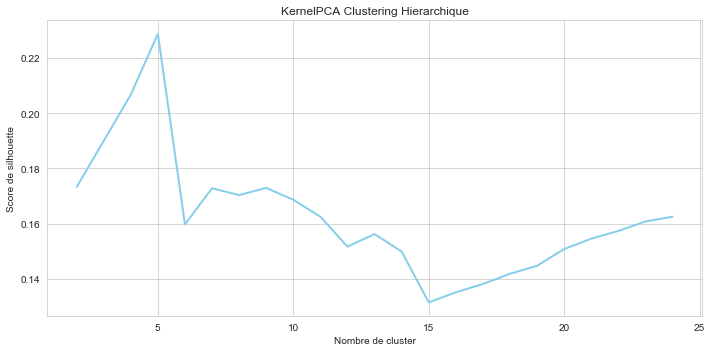

In [23]:
best_cluster_hier(X_kpca_projected, "KernelPCA")

### 5.3 - T-SNE
#### 5.3.1 - Decomposition et projection

In [24]:
X_tsne = tsne_projected(X)

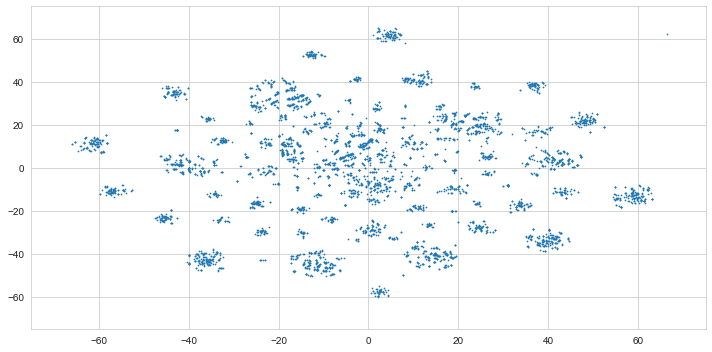

In [25]:
plt.figure(figsize=(10, 5))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], s=0.5)
plt.xlim(-75, 75)
plt.ylim(-75, 75)
plt.tight_layout()
plt.show()

#### 5.3.2 - Clustering
##### 5.3.2.1 - K-means

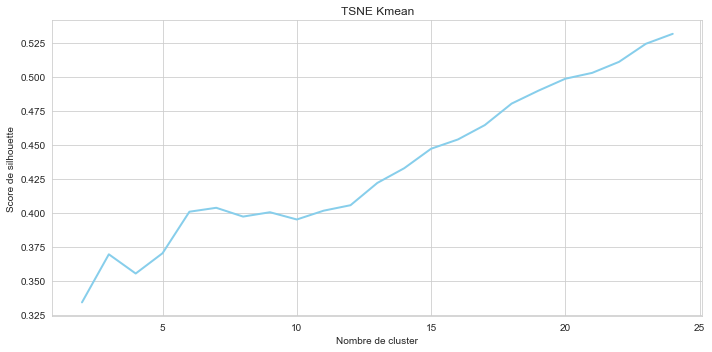

In [26]:
best_cluster_kmean(X_tsne, "TSNE")

##### 5.3.2.2 - Clustering Hierarchique

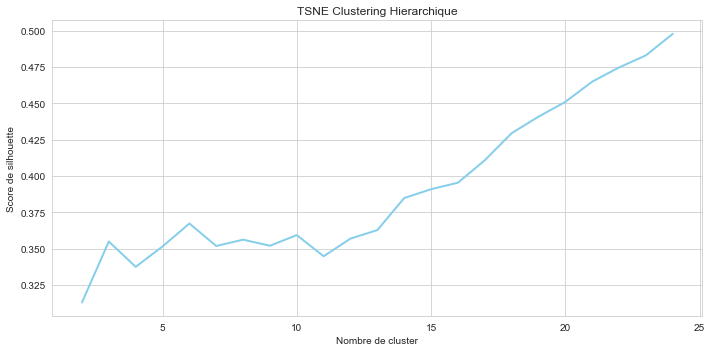

In [27]:
best_cluster_hier(X_tsne, "TSNE")

### 5.4 - MDS
#### 5.4.1 - Decomposition et projection

In [28]:
X_mds = mds_projected(X)

#### 5.4.2 - Clustering
##### 5.4.2.1 - K-means

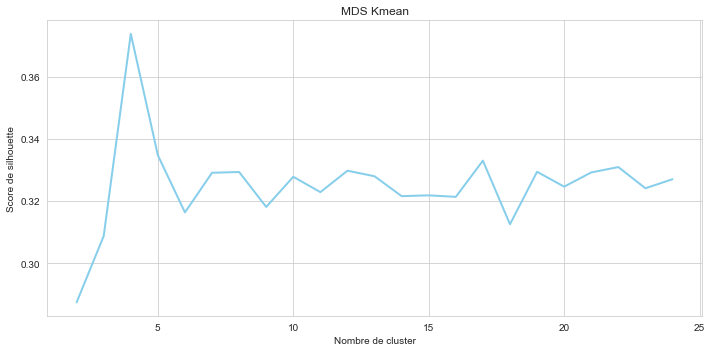

In [29]:
best_cluster_kmean(X_mds, "MDS")

##### 5.4.2.2 - Clustering Hierarchique

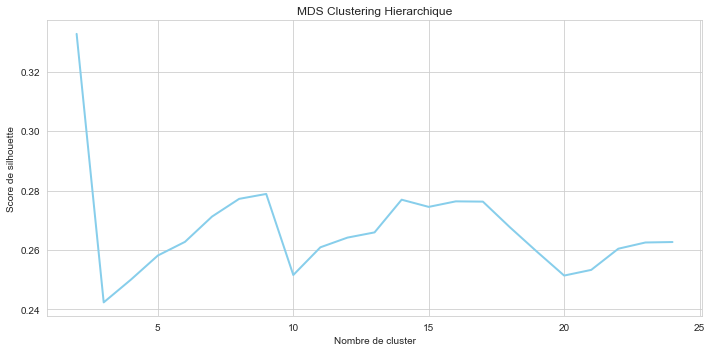

In [30]:
best_cluster_hier(X_mds, "MDS")

### 5.5 - ISO Map
#### 5.5.1 - Decomposition et projection

In [31]:
X_isomap = isomap_projected(X)

#### 5.5.2 - Clustering
##### 5.5.2.1 - K-means

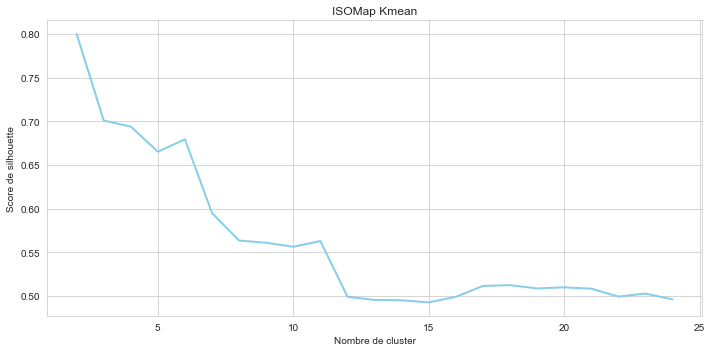

In [32]:
best_cluster_kmean(X_isomap, "ISOMap")

##### 5.5.2.2 - Clustering Hierarchique

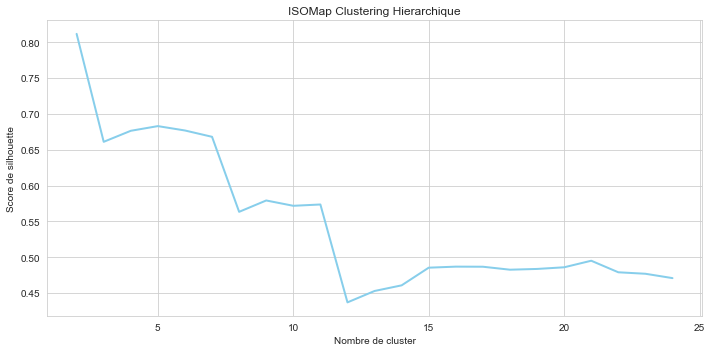

In [33]:
best_cluster_hier(X_isomap, "ISOMap")

### 5.6 - Suppression des variables inutiles

In [ ]:
del X_isomap
del X_pca_projected
del X_kpca_projected
del X_tsne
del X_mds
del client
del components
del dbscan_clust
del dbscan_labels
del kpca
del n_clusters
del pca
del standardize

## 6 - Choix du meilleur modèle

### 6.1 - KernelPCA (10 composantes) puis KMeans avec 11 Clusters

In [7]:
X_kpca_projected = kpca_projected(10, X)

In [8]:
data_3_months['cluster_kpca_km'] = kmean_labels(11, X_kpca_projected)

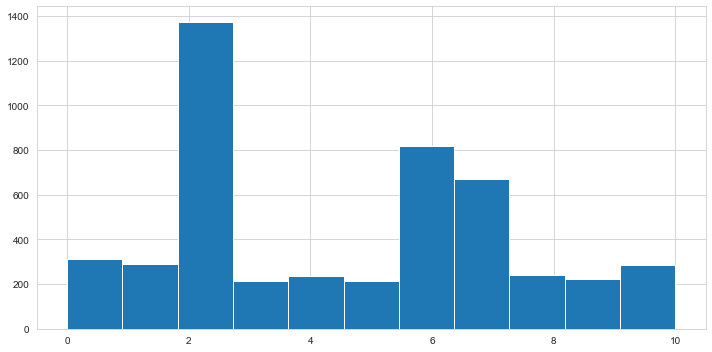

In [9]:
plt.figure(figsize=(10, 5))
plt.hist(data_3_months['cluster_kpca_km'], bins=11)
plt.tight_layout()
plt.show()

In [10]:
print('taille cluster max: {}'.format(
    max(data_3_months.groupby(['cluster_kpca_km']).size())))
print('taille cluster min: {}'.format(
    min(data_3_months.groupby(['cluster_kpca_km']).size())))

taille cluster max: 1374
taille cluster min: 212


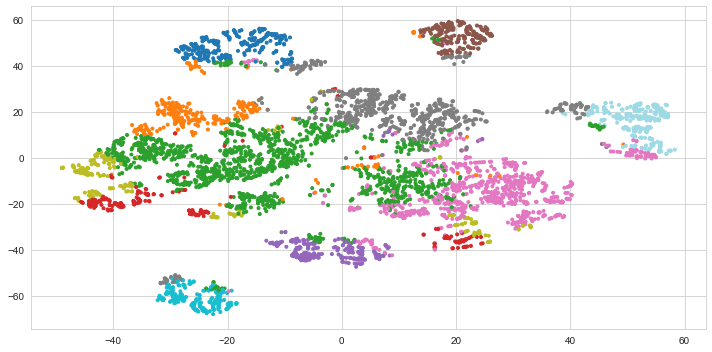

In [11]:
plot_with_tsne(X_kpca_projected, data_3_months["cluster_kpca_km"])

In [12]:
del X_kpca_projected

### 6.2 - ISOMap (2 composantes) puis KMeans avec 6 Clusters

In [44]:
X_isomap = isomap_projected(X)

In [45]:
data_3_months['cluster_iso_km'] = kmean_labels(6, X_isomap)

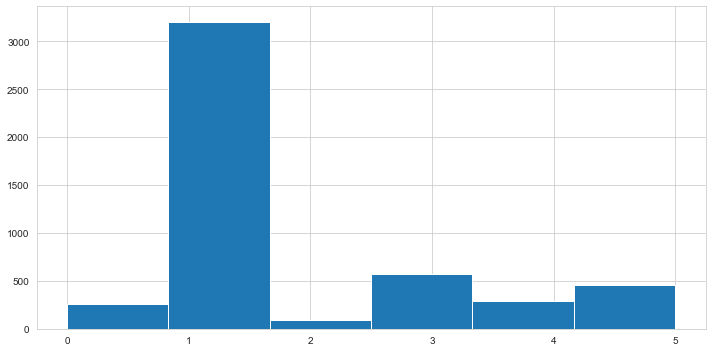

In [46]:
plt.figure(figsize=(10, 5))
plt.hist(data_3_months['cluster_iso_km'], bins=6)
plt.tight_layout()
plt.show()

In [47]:
print('taille cluster max: {}'.format(
    max(data_3_months.groupby(['cluster_iso_km']).size())))
print('taille cluster min: {}'.format(
    min(data_3_months.groupby(['cluster_iso_km']).size())))

taille cluster max: 3205
taille cluster min: 92


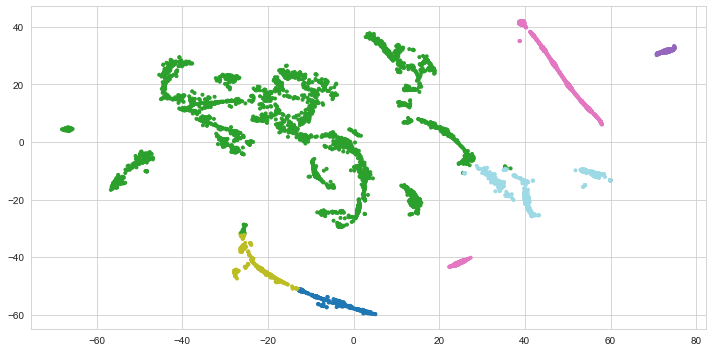

In [48]:
plot_with_tsne(X_isomap, data_3_months["cluster_iso_km"])

In [49]:
del X_isomap

### 6.3 - TSNE (2 composantes) puis KMeans avec 17 Clusters

In [13]:
X_tsne = tsne_projected(X)

In [14]:
data_3_months['cluster_tsne_km'] = kmean_labels(17, X_tsne)

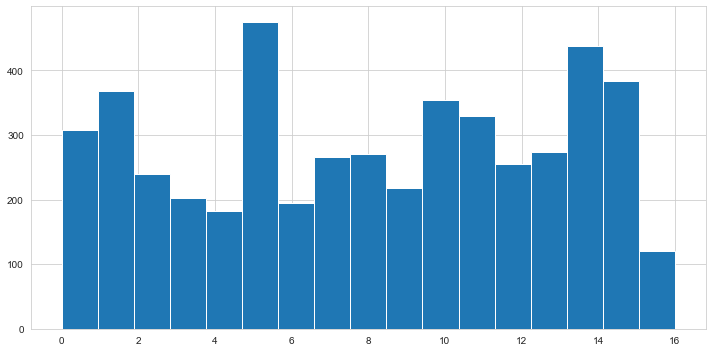

In [15]:
plt.figure(figsize=(10, 5))
plt.hist(data_3_months['cluster_tsne_km'], bins=17)
plt.tight_layout()
plt.show()

In [16]:
print('taille cluster max: {}'.format(
    max(data_3_months.groupby(['cluster_tsne_km']).size())))
print('taille cluster min: {}'.format(
    min(data_3_months.groupby(['cluster_tsne_km']).size())))

taille cluster max: 475
taille cluster min: 120


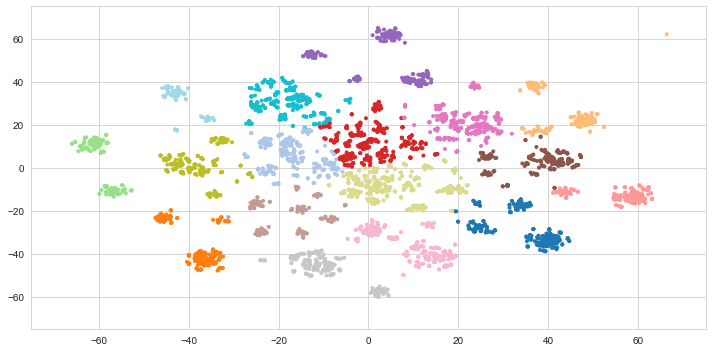

In [17]:
plt.figure(figsize=(10, 5))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], marker='.',
            c=data_3_months['cluster_tsne_km'], cmap=plt.get_cmap("tab20"))
plt.xlim(-75, 75)
plt.ylim(-75, 75)
plt.tight_layout()
plt.show()

In [18]:
del X_tsne

### 6.4 - PCA (50) + TSNE (2) avec KMeans (17 Clusters)

In [56]:
X_pca_projected = pca_projected(50, X)

In [57]:
X_tsne = tsne_projected(X_pca_projected)

In [58]:
data_3_months['cluster_pca_tsne_km'] = kmean_labels(17, X_tsne)

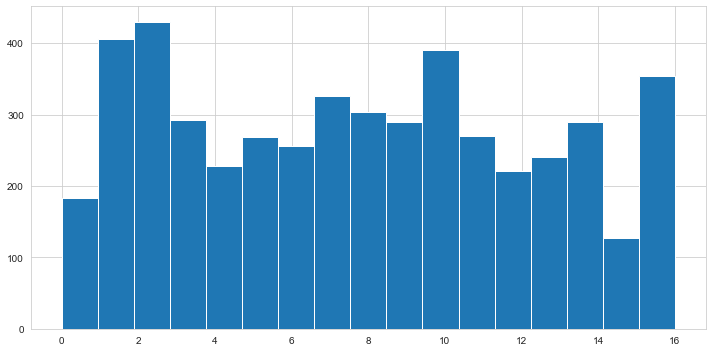

In [59]:
plt.figure(figsize=(10, 5))
plt.hist(data_3_months['cluster_pca_tsne_km'], bins=17)
plt.tight_layout()
plt.show()

In [60]:
print('taille cluster max: {}'.format(
    max(data_3_months.groupby(['cluster_pca_tsne_km']).size())))
print('taille cluster min: {}'.format(
    min(data_3_months.groupby(['cluster_pca_tsne_km']).size())))

taille cluster max: 430
taille cluster min: 127


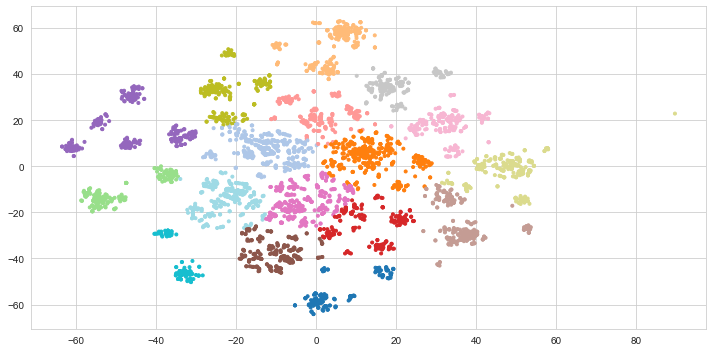

In [61]:
plt.figure(figsize=(10, 5))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], marker='.',
            c=data_3_months['cluster_pca_tsne_km'], cmap=plt.get_cmap("tab20"))
plt.xlim(-75, 75)
plt.ylim(-75, 75)
plt.tight_layout()
plt.show()

In [62]:
del X_pca_projected
del X_tsne

La réduction de dimension TSNE est très efficace, le fait de passer par une autre réduction de dimension avant TSNE ne fait change pas grand chose du coup, on passera seulement par du TSNE classique.

In [63]:
data_3_months = data_3_months.drop(columns=[
                                   "cluster_tsne_km", "cluster_iso_km", "cluster_pca_tsne_km", "cluster_kpca_km"])

In [19]:
def radar_plot():
    from math import pi
    categories = ["recency", "frequency", "monetary",
                  "payment_value_mean", "review_score_mean"]
    values = data_3_months[categories].mean().values.flatten().tolist()
    values += values[:1]

    angles = [n / float(len(categories)) * 2 *
              pi for n in range(len(categories))]
    angles += angles[:1]

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(
        10, 5), subplot_kw=(dict(polar=True)))

    plt.xticks(angles[:-1], categories, color='grey', size=12)
    plt.yticks(np.arange(1, 6), ["1", "2", "3",
                                 "4", "5"], color='grey', size=12)
    ax.set_rlabel_position(30)
    color_rad = ["skyblue", "red", "green", "magenta", "orange"]

    for i, idx in enumerate(data_3_months["cluster_tsne_km"].value_counts().nlargest(5).index):
        val = data_3_months.groupby(
            "cluster_tsne_km").mean().loc[idx][categories].tolist()
        val += val[:1]
        ax.plot(angles, val, lw=1, ls='solid', label="Cluster {}".format(idx))
        ax.fill(angles, val, color_rad[i], alpha=0.2)

    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.show()

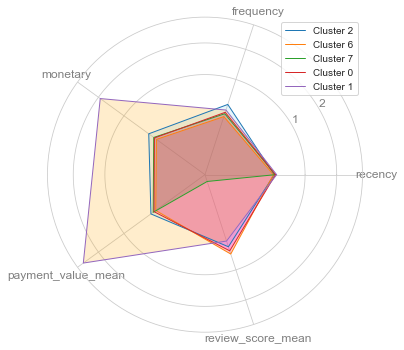

In [20]:
radar_plot()

In [21]:
data_result = pd.DataFrame(index=data_all.index)

In [22]:
data_result['cluster_3_months'] = data_3_months['cluster_tsne_km']
data_result

,cluster_3_months
customer_unique_id,
0000366f3b9a7992bf8c76cfdf3221e2,NaN
0000b849f77a49e4a4ce2b2a4ca5be3f,NaN
0000f46a3911fa3c0805444483337064,2.0
0000f6ccb0745a6a4b88665a16c9f078,NaN
0004aac84e0df4da2b147fca70cf8255,NaN
...,...
fffcf5a5ff07b0908bd4e2dbc735a684,NaN
fffea47cd6d3cc0a88bd621562a9d061,NaN
ffff371b4d645b6ecea244b27531430a,2.0


In [23]:
del X
del data_3_months

## 7 - Clustering sur les autres jeux de données
### 7.1 - Normalisation

In [24]:
standardize = preprocessing.StandardScaler(
    copy=True, with_mean=True, with_std=True)

In [25]:
standardize.fit(data_6_months.iloc[:])
data_6_months = standardize.transform(data_6_months.iloc[:])

In [106]:
standardize.fit(data_9_months.iloc[:])
data_9_months = standardize.transform(data_9_months.iloc[:])

In [107]:
standardize.fit(data_12_months.iloc[:])
data_12_months = standardize.transform(data_12_months.iloc[:])

In [108]:
standardize.fit(data_15_months.iloc[:])
data_15_months = standardize.transform(data_15_months.iloc[:])

In [109]:
standardize.fit(data_18_months.iloc[:])
data_18_months = standardize.transform(data_18_months.iloc[:])

In [110]:
standardize.fit(data_all.iloc[:])
data_all = standardize.transform(data_all.iloc[:])

### 7.2 - Réduction de dimension

In [26]:
X_6 = data_6_months.values
X_9 = data_9_months.values
X_12 = data_12_months.values
X_15 = data_15_months.values
X_18 = data_18_months.values
X_all = data_all.values

#### 7.2.1 - 6 mois

In [27]:
kpca_6 = decomposition.KernelPCA(n_components=X_6.shape[1], kernel="cosine")
kpca_6.fit(X_6)

KernelPCA(alpha=1.0, coef0=1, copy_X=True, degree=3, eigen_solver='auto',
          fit_inverse_transform=False, gamma=None, kernel='cosine',
          kernel_params=None, max_iter=None, n_components=107, n_jobs=None,
          random_state=None, remove_zero_eig=False, tol=0)

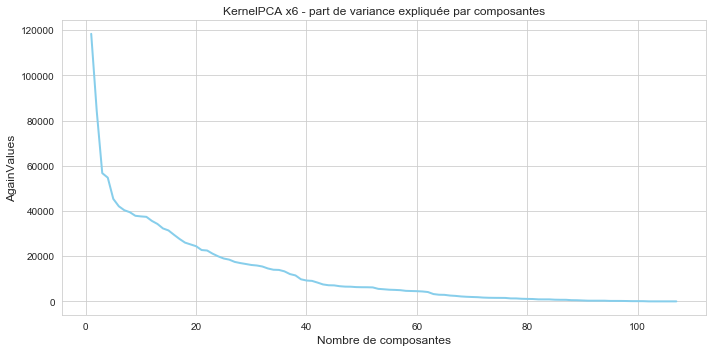

In [28]:
components = range(1, len(kpca_6.lambdas_)+1)
plt.figure(figsize=(10, 5))
plt.plot(components, kpca_6.lambdas_*100, color='skyblue', lw=2)
plt.xlabel('Nombre de composantes', fontsize=12)
plt.ylabel('AgainValues', fontsize=12)
plt.title('KernelPCA x6 - part de variance expliquée par composantes')
plt.tight_layout()
plt.show()

In [114]:
X_6_kpca_projected = kpca_projected(10, X_6)

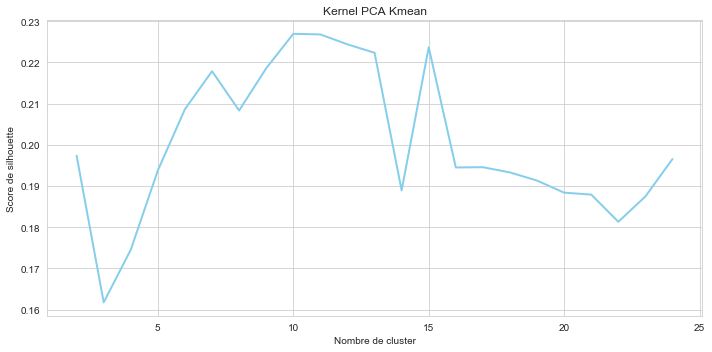

In [115]:
best_cluster_kmean(X_6_kpca_projected, "Kernel PCA")

In [116]:
data_6_months['cluster_kpca_km'] = kmean_labels(10, X_6_kpca_projected)

In [117]:
data_result['cluster_6_months'] = data_6_months['cluster_kpca_km']

In [118]:
del X_6
del X_6_kpca_projected
del data_6_months
del kpca_6
del components

#### 7.2.2 - 9 mois

In [83]:
kpca_9 = decomposition.KernelPCA(n_components=X_9.shape[1], kernel="cosine")
kpca_9.fit(X_9)

KernelPCA(alpha=1.0, coef0=1, copy_X=True, degree=3, eigen_solver='auto',
          fit_inverse_transform=False, gamma=None, kernel='cosine',
          kernel_params=None, max_iter=None, n_components=111, n_jobs=None,
          random_state=None, remove_zero_eig=False, tol=0)

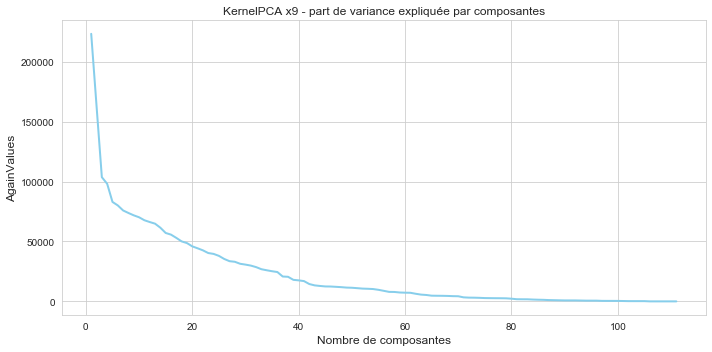

In [84]:
components = range(1, len(kpca_9.lambdas_)+1)
plt.figure(figsize=(10, 5))
plt.plot(components, kpca_9.lambdas_*100, color='skyblue', lw=2)
plt.xlabel('Nombre de composantes', fontsize=12)
plt.ylabel('AgainValues', fontsize=12)
plt.title('KernelPCA x9 - part de variance expliquée par composantes')
plt.tight_layout()
plt.show()

In [85]:
X_9_kpca_projected = kpca_projected(10, X_9)

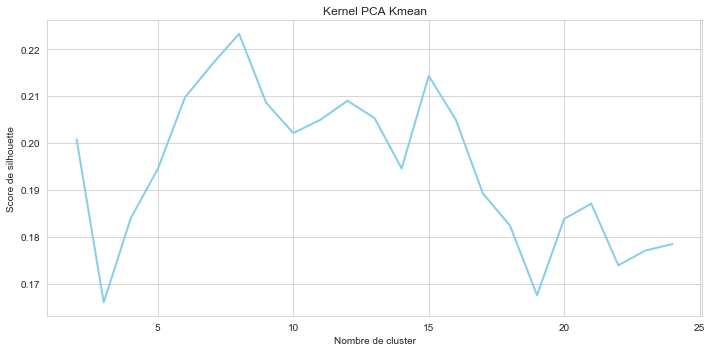

In [86]:
best_cluster_kmean(X_9_kpca_projected, "Kernel PCA")

In [88]:
data_9_months['cluster_kpca_km'] = kmean_labels(8, X_9_kpca_projected)

In [92]:
data_result['cluster_9_months'] = data_9_months['cluster_kpca_km']

In [89]:
del X_9
del X_9_kpca_projected
del components
del kpca_9
del standardize
del data_9_months

#### 7.2.3 - 12 mois

In [ ]:
kpca_12 = decomposition.KernelPCA(n_components=X_12.shape[1], kernel="cosine")
kpca_12.fit(X_12)

In [ ]:
components = range(1, len(kpca_12.lambdas_)+1)
plt.figure(figsize=(10, 5))
plt.plot(components, kpca_12.lambdas_*100, color='skyblue', lw=2)
plt.xlabel('Nombre de composantes', fontsize=12)
plt.ylabel('AgainValues', fontsize=12)
plt.title('KernelPCA x12 - part de variance expliquée par composantes')
plt.tight_layout()
plt.show()

In [ ]:
X_12_kpca_projected = kpca_projected(10, X_12)

In [ ]:
best_cluster_kmean(X_12_kpca_projected, "Kernel PCA")

In [ ]:
data_12_months['cluster_kpca_km'] = kmean_labels(10, X_12_kpca_projected)

In [ ]:
data_result['cluster_12_months'] = data_12_months['cluster_kpca_km']

In [ ]:
del X_12
del X_12_kpca_projected
del components
del kpca_12
del standardize
del data_12_months

#### 7.2.4 - 15 mois

In [ ]:
kpca_15 = decomposition.KernelPCA(n_components=X_15.shape[1], kernel="cosine")
kpca_15.fit(X_15)

In [ ]:
components = range(1, len(kpca_15.lambdas_)+1)
plt.figure(figsize=(10, 5))
plt.plot(components, kpca_15.lambdas_*100, color='skyblue', lw=2)
plt.xlabel('Nombre de composantes', fontsize=12)
plt.ylabel('AgainValues', fontsize=12)
plt.title('KernelPCA x15 - part de variance expliquée par composantes')
plt.tight_layout()
plt.show()

In [ ]:
X_15_kpca_projected = kpca_projected(10, X_15)

In [ ]:
best_cluster_kmean(X_15_kpca_projected, "Kernel PCA")

In [ ]:
data_15_months['cluster_kpca_km'] = kmean_labels(10, X_15_kpca_projected)

In [ ]:
data_result['cluster_15_months'] = data_15_months['cluster_kpca_km']

In [ ]:
del X_15
del X_15_kpca_projected
del components
del kpca_15
del standardize
del data_15_months

#### 7.2.5 - 18 mois

In [ ]:
kpca_18 = decomposition.KernelPCA(n_components=X_18.shape[1], kernel="cosine")
kpca_18.fit(X_18)

In [ ]:
components = range(1, len(kpca_18.lambdas_)+1)
plt.figure(figsize=(10, 5))
plt.plot(components, kpca_18.lambdas_*100, color='skyblue', lw=2)
plt.xlabel('Nombre de composantes', fontsize=12)
plt.ylabel('AgainValues', fontsize=12)
plt.title('KernelPCA x18 - part de variance expliquée par composantes')
plt.tight_layout()
plt.show()

In [ ]:
X_18_kpca_projected = kpca_projected(10, X_18)

In [ ]:
best_cluster_kmean(X_18_kpca_projected, "Kernel PCA")

In [ ]:
data_18_months['cluster_kpca_km'] = kmean_labels(10, X_18_kpca_projected)

In [ ]:
data_result['cluster_18_months'] = data_18_months['cluster_kpca_km']

In [ ]:
del X_18
del X_18_kpca_projected
del components
del kpca_18
del standardize
del data_18_months

#### 7.2.6 - all

In [ ]:
kpca_all = decomposition.KernelPCA(
    n_components=X_all.shape[1], kernel="cosine")
kpca_all.fit(X_all)

In [ ]:
components = range(1, len(kpca_all.lambdas_)+1)
plt.figure(figsize=(10, 5))
plt.plot(components, kpca_all.lambdas_*100, color='skyblue', lw=2)
plt.xlabel('Nombre de composantes', fontsize=12)
plt.ylabel('AgainValues', fontsize=12)
plt.title('KernelPCA x18 - part de variance expliquée par composantes')
plt.tight_layout()
plt.show()

In [ ]:
X_all_kpca_projected = kpca_projected(10, X_all)

In [ ]:
best_cluster_kmean(X_all_kpca_projected, "Kernel PCA")

In [ ]:
data_all_months['cluster_kpca_km'] = kmean_labels(10, X_all_kpca_projected)

In [ ]:
data_result['cluster_all'] = data_all['cluster_kpca_km']

In [ ]:
del X_all
del X_all_kpca_projected
del components
del kpca_all
del standardize
del data_all_months

## 8 - Analyse des résultats

In [ ]:
data_result

In [ ]:
data_based_3_months = data_result[:][data_result["cluster_3_months"].notnull()]

In [ ]:
data_frequency = pd.DataFrame(index=["AMI Score", 'AR Score'])

In [ ]:
AMI_3_months = metrics.adjusted_mutual_info_score(data_based_3_months["cluster_3_months"],
                                                  data_based_3_months["cluster_3_months"],
                                                  average_method='arithmetic')
AR_3_months = metrics.adjusted_rand_score(data_based_3_months["cluster_3_months"],
                                          data_based_3_months["cluster_3_months"])
NMI_3_months = metrics.normalized_mutual_info_score(data_based_3_months["cluster_3_months"],
                                                    data_based_3_months["cluster_3_months"],
                                                    average_method='arithmetic')

In [ ]:
AMI_6_months = metrics.adjusted_mutual_info_score(data_based_3_months["cluster_3_months"],
                                                  data_based_3_months["cluster_6_months"],
                                                  average_method='arithmetic')
AR_6_months = metrics.adjusted_rand_score(data_based_3_months["cluster_3_months"],
                                          data_based_3_months["cluster_6_months"])
NMI_6_months = metrics.normalized_mutual_info_score(data_based_3_months["cluster_3_months"],
                                                    data_based_3_months["cluster_6_months"],
                                                    average_method='arithmetic')

In [ ]:
AMI_9_months = metrics.adjusted_mutual_info_score(data_based_3_months["cluster_3_months"],
                                                  data_based_3_months["cluster_9_months"],
                                                  average_method="arithmetic")
AR_9_months = metrics.adjusted_rand_score(data_based_3_months["cluster_3_months"],
                                          data_based_3_months["cluster_9_months"])
NMI_9_months = metrics.normalized_mutual_info_score(data_based_3_months["cluster_3_months"],
                                                    data_based_3_months["cluster_9_months"],
                                                    average_method='arithmetic')

In [ ]:
AMI_12_months = metrics.adjusted_mutual_info_score(data_based_3_months["cluster_3_months"],
                                                   data_based_3_months["cluster_12_months"],
                                                   average_method="arithmetic")
AR_12_months = metrics.adjusted_rand_score(data_based_3_months["cluster_3_months"],
                                           data_based_3_months["cluster_12_months"])
NMI_12_months = metrics.normalized_mutual_info_score(data_based_3_months["cluster_3_months"],
                                                     data_based_3_months["cluster_12_months"],
                                                     average_method='arithmetic')

In [ ]:
AMI_15_months = metrics.adjusted_mutual_info_score(data_based_3_months["cluster_3_months"],
                                                   data_based_3_months["cluster_15_months"],
                                                   average_method="arithmetic")
AR_15_months = metrics.adjusted_rand_score(data_based_3_months["cluster_3_months"],
                                           data_based_3_months["cluster_15_months"])
NMI_15_months = metrics.normalized_mutual_info_score(data_based_3_months["cluster_3_months"],
                                                     data_based_3_months["cluster_15_months"],
                                                     average_method='arithmetic')

In [ ]:
AMI_18_months = metrics.adjusted_mutual_info_score(data_based_3_months["cluster_3_months"],
                                                   data_based_3_months["cluster_18_months"],
                                                   average_method="arithmetic")
AR_18_months = metrics.adjusted_rand_score(data_based_3_months["cluster_3_months"],
                                           data_based_3_months["cluster_18_months"])
NMI_18_months = metrics.normalized_mutual_info_score(data_based_3_months["cluster_3_months"],
                                                     data_based_3_months["cluster_18_months"],
                                                     average_method='arithmetic')

In [ ]:
AMI_all = metrics.adjusted_mutual_info_score(data_based_3_months["cluster_3_months"],
                                             data_based_3_months["cluster_all"],
                                             average_method="arithmetic")
AR_all = metrics.adjusted_rand_score(data_based_3_months["cluster_3_months"],
                                     data_based_3_months["cluster_all"])
NMI_all = metrics.normalized_mutual_info_score(data_based_3_months["cluster_3_months"],
                                               data_based_3_months["cluster_all"],
                                               average_method='arithmetic')

In [ ]:
data_frequency.loc["AMI Score", "cluster_3_months"] = AMI_3_months
data_frequency.loc["AMI Score", "cluster_6_months"] = AMI_6_months
data_frequency.loc["AMI Score", "cluster_9_months"] = AMI_9_months
data_frequency.loc["AMI Score", "cluster_12_months"] = AMI_12_months
data_frequency.loc["AMI Score", "cluster_15_months"] = AMI_15_months
data_frequency.loc["AMI Score", "cluster_18_months"] = AMI_18_months
data_frequency.loc["AMI Score", "cluster_all"] = AMI_all

data_frequency.loc["AR Score", "cluster_3_months"] = AR_3_months
data_frequency.loc["AR Score", "cluster_6_months"] = AR_6_months
data_frequency.loc["AR Score", "cluster_9_months"] = AR_9_months
data_frequency.loc["AR Score", "cluster_12_months"] = AR_12_months
data_frequency.loc["AR Score", "cluster_15_months"] = AR_15_months
data_frequency.loc["AR Score", "cluster_18_months"] = AR_18_months
data_frequency.loc["AR Score", "cluster_all"] = AR_all

data_frequency.loc["NMI Score", "cluster_3_months"] = NMI_3_months
data_frequency.loc["NMI Score", "cluster_6_months"] = NMI_6_months
data_frequency.loc["NMI Score", "cluster_9_months"] = NMI_9_months
data_frequency.loc["NMI Score", "cluster_12_months"] = NMI_12_months
data_frequency.loc["NMI Score", "cluster_15_months"] = NMI_15_months
data_frequency.loc["NMI Score", "cluster_18_months"] = NMI_18_months
data_frequency.loc["NMI Score", "cluster_all"] = NMI_all

data_frequency.loc["# Cluster", "cluster_3_months"] = 11
data_frequency.loc["# Cluster", "cluster_6_months"] = 10
data_frequency.loc["# Cluster", "cluster_9_months"] = 8
data_frequency.loc["# Cluster", "cluster_12_months"] = 10
data_frequency.loc["# Cluster", "cluster_15_months"] = 10
data_frequency.loc["# Cluster", "cluster_18_months"] = 10
data_frequency.loc["# Cluster", "cluster_all"] = 10

In [ ]:
data_frequency

In [ ]:
data_frequency.to_csv("data/result.csv")